# Метод Левенберга — Марквардта и решение задачи P*n*P

## Как всегда долгое вступление

Как обычно импортируем библиотеки:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, minimize

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

Сегодня мы будем решать задачу P*n*P путем численной минимизации суммы квадратов. 3D-точки мы возьмем на поверхности головы лисы (обозначены на картинке красными точками, заодно зеленым нарисована 3D-модель поверхности):
![](./fig/target.png)

При искомом правильном положении камеры (как на первой картинке) 3D-точки поверхности лисы спроецируются на кадр прямо поверх собственно изображения лисы.

В качестве начального положения мы возьмем существенно неправильную позицию камеры. Проекция поверхности лисы при такой позиции выглядит вот так:
![](./fig/initial.png)

Зададим все данные, с которыми будем сегодня работать.

Картинка с лисой, чтобы было понятнее и веселее:

In [2]:
IMAGE_RGB = cv2.cvtColor(cv2.imread('./fox_head.png'), cv2.COLOR_BGR2RGB)

Матрица внутренних параметров камеры в формате OpenGL (камера смотрит в отрицательном направлении оси $z$):

In [3]:
PROJ = np.array([
    [1147.982056, 0, -256.000000, 0],
    [0, 1147.982056, -194.500000, 0],
    [0, 0, -1.000020, -0.200002],
    [0, 0, -1, 0],
])

Исходная и идеальная позиции камеры (в виде видовых матриц):

In [4]:
VIEW_0 = np.array([
    [0.861142, -0.307369, -0.404917, 208.272278],
    [0.105053, 0.886913, -0.449832, -43.346642],
    [0.497391, 0.344832, 0.796048, -2010.276978],
    [0, 0, 0, 1]
])
VIEW_GT = np.array([
    [0.952290, 0.172852, 0.251527, -19.438843],
    [-0.104329,  0.958875,  -0.263958, 88.359253],
    [-0.286809, 0.225123,  0.931161,  -1895.653687],
    [0, 0, 0, 1]
])

3D-точки в мировом пространстве:

In [5]:
POINTS_3D = np.array([
    [-145.638641, 156.886307, -72.267281],
    [146.078400, 154.259949, -59.589867],
    [1.025537, -59.998959, 310.193695],
    [-130.684082, -146.670700, 84.652412],
    [129.107666, -127.789337, 94.851982],
    [-54.120178, 8.372103, 25.370705],
    [2.454392, -175.375244, 185.457535],
    [-123.819229, -95.673820, -51.423004],
    [66.226601, -23.369894, 80.602280]
])

2D-точки: точные, зашумленные нормальным шумом и с двумя выбросами:

In [6]:
POINTS_2D_PRECISE = np.array([
    [165.184372, 360.722565],
    [332.996307, 333.293762],
    [290.843628, 158.262054],
    [162.287384, 155.867783],
    [320.521759, 149.955887],
    [216.912140, 253.511810],
    [255.500031, 110.500031],
    [156.750015, 208.250000],
    [293.249939, 218.000015]
])

POINTS_2D_WITH_NOISE = POINTS_2D_PRECISE + np.random.normal(scale=3.0, size=POINTS_2D_PRECISE.shape)

POINTS_2D_WITH_OUTLIERS = POINTS_2D_WITH_NOISE.copy()
POINTS_2D_WITH_OUTLIERS[3, :] += np.array([-58, 18])
POINTS_2D_WITH_OUTLIERS[8, :] += np.array([24, -42])

Определим вспомогательные функции:

In [7]:
def to_homogeneous(points3d):
    return np.pad(points3d, ((0, 0), (0, 1)), constant_values=(0, 1.0))


def from_homogeneous(points4d):
    return points4d[:, :3] / points4d[:, 3].reshape(-1, 1)


def transform_points3d(points, mat4x4):
    points4d = to_homogeneous(points)
    return from_homogeneous((mat4x4 @ points4d.T).T)


def project_points3d(points3d, mat4x4):
    return transform_points3d(points3d, mat4x4)[:, :2]


def draw_residuals(points2d, view_mat):
    points2d = map(tuple, points2d.astype(np.int_))
    projected = map(tuple, project_points3d(POINTS_3D, PROJ @ view_mat).astype(np.int_))
    img = cv2.flip(IMAGE_RGB, 0)
    for p2d, prj in zip(points2d, projected):
        cv2.line(img, p2d, prj, (0, 255, 0))
        cv2.circle(img, p2d, 3, (255, 0, 0), -1)
        cv2.circle(img, prj, 3, (0, 0, 255), -1)
    img = cv2.flip(img, 0)
    return plt.imshow(img)

Нарисуем невязки точек c шумом в начальной позиции...

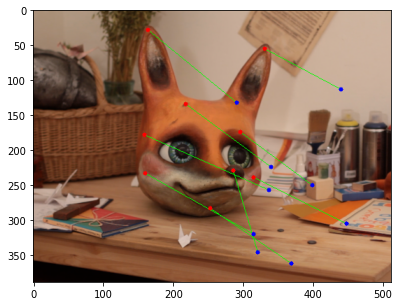

In [8]:
draw_residuals(POINTS_2D_WITH_NOISE, VIEW_0)

...и в идеальной позиции:

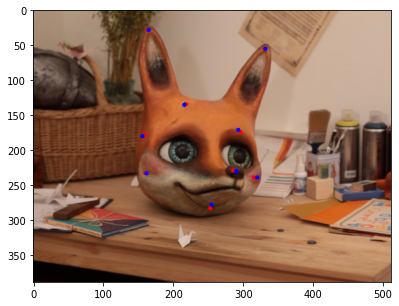

In [9]:
draw_residuals(POINTS_2D_WITH_NOISE, VIEW_GT)

## Собственно задачи

### 1. Параметризация

В первую очередь нам надо научиться из матрицы $4 \times 4$ получать вектор из шести параметров, пригодный для оптимизации. Давайте условимся, что первые три компоненты этого вектора будут отвечать за вращение, а последние — за параллельный перенос.

Напишите функции `mat4x4_to_vec6` и `vec6_to_mat4x4`, переводящие матрицу в вектор параметров и обратно. Используйте функции `cv2.Rodrigues` и `np.hstack`.

In [10]:
def mat4x4_to_vec6(mat4x4):
    # TODO
    return None


def vec6_to_mat4x4(vec6):
    # TODO
    return None

Сразу посчитаем начальные параметры (заодно и проверим, что написали):

In [11]:
VEC6_0 = mat4x4_to_vec6(VIEW_0)
assert np.linalg.norm(vec6_to_mat4x4(VEC6_0) - VIEW_0) < 1e-6

### 2. Вычисление невязок и суммы квадратов

Теперь давайте напишем функции, которые нам понадобятся для оптимизации. Входными аргументами будут вектор параметров и 2D-точки (потому что мы будем пробовать разные 2D-точки), а матрицу проекции `PROJ` и 3D-точки `POINTS_3D` будем брать из глобальных констант.

In [12]:
def calc_residuals(vec6, points2d):
    # TODO
    return None


def calc_sum_of_squares(vec6, points2d):
    # TODO
    return None

In [13]:
assert calc_sum_of_squares(mat4x4_to_vec6(VIEW_GT), POINTS_2D_PRECISE) < 1e-6

### 3. Оптимизация

По-хорошему стоит считать производные точно, если есть возможность. Но мы пока будем пользоваться тем, что SciPy умеет считать производные численно — так гораздо проще.

#### Градиентный спуск

Давайте для начала запустим градиентный спуск, чтобы было с чем сравнивать метод Левенберга — Марквардта.

In [14]:
cg_result = minimize(
    fun=calc_sum_of_squares,
    args=(POINTS_2D_WITH_NOISE,),
    x0=VEC6_0,
    options=dict(disp=True),
    method='CG'
)
cg_vec6 = cg_result.x
cg_view = vec6_to_mat4x4(cg_vec6)

In [15]:
print('Before:', calc_sum_of_squares(VEC6_0, POINTS_2D_WITH_NOISE))
print('After:', calc_sum_of_squares(cg_vec6, POINTS_2D_WITH_NOISE))

#### Собственно метод Левенберга — Марквардта

Воспользуйтесь функцией `least_squares` с параметрами `method='lm'` и `verbose=1` для того, чтобы запустить оптимизацию. Сравните, насколько быстрее сошелся метод.

In [16]:
lm_result = None  # TODO
lm_vec6 = lm_result.x
lm_view = vec6_to_mat4x4(lm_vec6)

In [17]:
print('Before:', calc_sum_of_squares(VEC6_0, POINTS_2D_WITH_NOISE))
print('After:', calc_sum_of_squares(lm_vec6, POINTS_2D_WITH_NOISE))

Ну и посмотрим на картинку:

In [18]:
draw_residuals(POINTS_2D_WITH_NOISE, lm_view)

### 4. Выбросы

Запустите оптимизацию на точках с выбросами.

In [19]:
lm_result_outliers = None  # TODO
lm_vec6_outliers = lm_result_outliers.x
lm_view_outliers = vec6_to_mat4x4(lm_vec6_outliers)

Нарисуем невязки в идеальной позиции...

In [20]:
draw_residuals(POINTS_2D_WITH_OUTLIERS, VIEW_GT)

...и в найденной позиции:

In [21]:
draw_residuals(POINTS_2D_WITH_OUTLIERS, lm_view_outliers)

Должно быть заметно, что выбросы сильно повлияли на решение.

Воспользуйтесь параметром `loss` функции `least_squares`, чтобы исправить положение (параметр `method` придется поменять на `trf`).

In [22]:
lm_result_loss = None  # TODO
lm_vec6_loss = lm_result_loss.x
lm_view_loss = vec6_to_mat4x4(lm_vec6_loss)

Даже на глаз должно быть заметно, что стало лучше.

In [23]:
draw_residuals(POINTS_2D_WITH_OUTLIERS, lm_view_loss)

### 5. Немного ускорим градиентный спуск

Отмасштабируйте вектор параметров оптимизации так, чтобы градиентный спуск сходился быстрее.

In [24]:
def upscale(vec6):
    # TODO
    return None


def downscale(vec6):
    # TODO
    return None


cg_result_fast = minimize(
    fun=lambda v, p: calc_sum_of_squares(upscale(v), p),
    args=(POINTS_2D_WITH_NOISE,),
    x0=downscale(VEC6_0),
    options=dict(disp=True),
    method='CG'
)
cg_vec6_fast = upscale(cg_result_fast.x)
cg_view_fast = vec6_to_mat4x4(cg_vec6_fast)

In [25]:
print('Before:', calc_sum_of_squares(VEC6_0, POINTS_2D_WITH_NOISE))
print('After:', calc_sum_of_squares(cg_vec6_fast, POINTS_2D_WITH_NOISE))

### 6. Честная производная

Реализуйте функцию `calc_jacobian`, которая бы аналитически вычисляла матрицу Якоби.

In [26]:
def calc_jacobian(vec6, points2d):
    # TODO
    return None

Запустите оптимизацию и проверьте себя.

In [27]:
lm_result_honest = None  # TODO
draw_residuals(POINTS_2D_WITH_NOISE, vec6_to_mat4x4(lm_result_honest.x))